# load data

mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = '/content/drive/Shareddrives/Polymers-Data'

Mounted at /content/drive


load the labels from the first *Soft Matter* paper

In [ ]:
import pandas as pd
import requests

url = 'https://pennstateoffice365-my.sharepoint.com/:t:/g/personal/wfr5091_psu_edu/EQKqkRVoTbZNlqaT54fExqUB2klw7qbPm9d__52XNq-Ciw?e=awj46t&download=1'
response = requests.get(url)
with open('polymers-umap-kmeans.txt', 'w') as fid:
    fid.write(response.text)

url = 'https://pennstateoffice365-my.sharepoint.com/:t:/g/personal/wfr5091_psu_edu/ET7ktm96Fc1JoYs-Na8TcYIBp2S_sZV9ibIyzyV8VIvKYg?e=SHIwxC&download=1'
response = requests.get(url)
with open('polymers-umap-random.txt', 'w') as fid:
    fid.write(response.text)

all_data = []
for keyword in ['random', 'kmeans']:
    data = pd.read_csv(f'polymers-umap-{keyword}.txt', header=None, names=['Sequence', 'Z0', 'Z1'])
    all_data.append(data)

all_data = pd.concat(all_data)
print(len(all_data))
all_data

2038


,Sequence,Z0,Z1
0,AAAAAABBBBBBBBAAAAAA,5.671495,-0.404117
1,AAAABBAABABBBBBAAAAA,2.667750,-0.823994
2,AAAABBABBBBABABAAAAA,4.233039,-0.201995
3,AAAABBBAABABBBABAAAA,1.941323,0.588821
4,AAAABBBABABBABBAAAAA,0.554551,0.050845
...,...,...,...
1017,BBBBBBABAAAAAAAABAAA,5.918677,-3.045271
1018,BBBBBBBAAAAAABAAAAAA,-1.495865,-2.462502
1019,BBBBBBBAAAAABAAAAAAA,-1.076681,-2.863034
1020,BBBBBBBAABAAAAAAAAAA,4.458233,-4.845200


## alternate labels (don't use these)

In [ ]:
import os

target_dirs = ['full-space/AB-N500-kmeans-1024', 'full-space/AB-N500-random-1024']

all_data = []
for loc in target_dirs:
    data = pd.read_csv(os.path.join(drive_prefix, 'trajectories', loc, 'embeddings.csv'), index_col=0).loc[:, ['Sequence', 'Z0', 'Z1']]
    all_data.append(data)

all_data = pd.concat(all_data)
print(len(all_data))
all_data

2038


,Sequence,Z0,Z1
0,AAAABBBBBABABBAAAAAA,3.232272,-1.732373
1,AAAABBBBBBBABAAAAAAA,4.541366,-0.939862
2,AAABABABABBBBAABAAAA,6.303464,0.934619
3,AAABABABBBABABAABAAA,6.447819,0.887424
4,AAABBAABAAABBBBBAAAA,-1.636598,5.266265
...,...,...,...
1011,BBBBBAAABAAAAAABAABA,8.968448,-3.367814
1012,BBBBBAAABAAAABAABAAA,5.716132,4.974365
1013,BBBBBAAABAAABAAAAAAB,9.699635,-3.933966
1014,BBBBBABAAAAAABAAAABA,5.718490,-3.505640


## convert sequences to numpy array

In [ ]:
import numpy as np

AB_inv = {'A': 0, 'B': 1}
X = np.array([[AB_inv[x] for x in s] for s in all_data['Sequence']])
print(X.shape)
print(np.sum(X, axis=1).mean())  # check if A/B are switched
y = np.array(all_data.loc[:, 'Z0':'Z1'].values)
print(y.shape)

(2038, 20)
8.0
(2038, 2)


## load the alpha shape for making the plots clear

In [ ]:
try:
    import alphashape
except:
    !pip install alphashape
    import alphashape

from shapely.geometry import Polygon
import numpy as np

alpha_shape = alphashape.alphashape(y, 1.0)

xH, yH = alpha_shape.boundary.coords.xy
hull = np.vstack([xH, yH]).T

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 646 kB 38.1 MB/s 


# regression on raw sequences

In [ ]:
def train_evaluate_model(model, dataset):
    Xtrain, Xtest, ytrain, ytest = dataset

    model = model.fit(Xtrain, ytrain)

    metrics = {}

    for name, thisX, thisy in [('train', Xtrain, ytrain),
                               ('test', Xtest, ytest)]:
        rsq = model.score(thisX, thisy)
        ypred = model.predict(thisX)
        residual = ypred - thisy
        rmse = np.sqrt(np.mean(residual**2))

        metrics[name] = {'rsq': rsq, 'rmse': rmse}

    return metrics

from matplotlib import pyplot as plt

def plot_parity(predict_method, dataset, name=None):
    Xtrain, Xtest, ytrain, ytest = dataset

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for thisX, thisy in [(Xtrain, ytrain), (Xtest, ytest)]:
        
        pred = predict_method(thisX)

        for i in range(2):
            ax = axes[i]
            ax.plot(thisy[:, i], pred[:, i], '.')
            ax.set_xlabel('Real $Z_%d$' % i)
            ax.set_ylabel('Predicted $Z_%d$' % i)
    
    if name is not None:
        axes[0].set_title(name)
    
    return

def plot_residuals(predict_method, dataset, name=None, reverse=False):
    Xtrain, Xtest, ytrain, ytest = dataset

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    k = 0
    for thisX, thisy in [(Xtrain, ytrain), (Xtest, ytest)]:
        if reverse:
            thisX = np.fliplr(thisX)

        pred_z = predict_method(thisX)
        real_z = thisy
        residuals = np.zeros([0, 2])
        for i in range(len(thisX)):
            residuals = np.vstack([residuals, real_z[i], pred_z[i], np.ones(2)*np.nan])
        # axes[k].plot(*real_z.T,' .', zorder=10)
        axes[k].plot(*pred_z.T,' .', zorder=10)
        axes[k].plot(*residuals.T)
        axes[k].set_aspect('equal', 'datalim')
        k += 1
    if name is not None:
        axes[0].set_title(name)
    return

check permutations for claim in the paper about topology!

In [ ]:
from sklearn import neural_network

base_metrics = []
X = np.array([[AB_inv[x] for x in s] for s in all_data['Sequence']])
dataset = model_selection.train_test_split(X, y, random_state=i)
Xtrain, Xtest, ytrain, ytest = dataset
for i in range(5):
    print(i)
    # train models
    kwargs = dict(random_state=i, max_iter=1000, alpha=0)
    model = neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(20, 20))
    metrics = train_evaluate_model(model, dataset)
    base_metrics.append(metrics)

all_metrics = []
for i in range(5):
    print(i)
    # set up data
    X = np.array([[AB_inv[x] for x in s] for s in all_data['Sequence']])
    # create permutation
    idx = np.arange(X.shape[1])
    np.random.shuffle(idx)
    Xp = X[:, idx]
    # create dataset
    dataset = model_selection.train_test_split(Xp, y, random_state=0)
    Xtrain, Xtest, ytrain, ytest = dataset
    # train models
    kwargs = dict(random_state=i, max_iter=1000, alpha=0)
    model = neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(20, 20))
    metrics = train_evaluate_model(model, dataset)
    all_metrics.append(metrics)

0
1
2
3
4
0


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


1
2
3
4


In [ ]:
base = [it['test']['rsq'] for it in base_metrics]
print(np.mean(base), np.std(base))

perf = [it['test']['rsq'] for it in all_metrics]
print(np.mean(perf), np.std(perf))

0.6844970277822494 0.013671574944432876
0.7006577875925115 0.013773013517612218


In [ ]:
from sklearn import model_selection

dataset = model_selection.train_test_split(X, y, random_state=0)
Xtrain, Xtest, ytrain, ytest = dataset

In [ ]:
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble

models = [linear_model.LinearRegression(),
          linear_model.Lasso(),
          linear_model.Ridge(),
          neighbors.KNeighborsRegressor(),
          ensemble.RandomForestRegressor(random_state=0)]

for model in models:
    print(model)
    metrics = train_evaluate_model(model, dataset)
    print(metrics)

# for model in models:
#     plot_parity(model.predict, dataset, name=str(model))

LinearRegression()
{'train': {'rsq': 0.46463027473205426, 'rmse': 3.292685573462766}, 'test': {'rsq': 0.4272355568197195, 'rmse': 3.422918944779494}}
Lasso()
{'train': {'rsq': -2.220446049250313e-16, 'rmse': 4.724155633144785}, 'test': {'rsq': -0.0007894165857464941, 'rmse': 4.864396310128621}}
Ridge()
{'train': {'rsq': 0.46475217582973777, 'rmse': 3.2921242518877314}, 'test': {'rsq': 0.4273965454869791, 'rmse': 3.422395219939181}}
KNeighborsRegressor()
{'train': {'rsq': 0.6399402123385918, 'rmse': 2.8388890464188443}, 'test': {'rsq': 0.4540475172679762, 'rmse': 3.5333151671998073}}
RandomForestRegressor(random_state=0)
{'train': {'rsq': 0.9507696219896874, 'rmse': 0.9679710946740996}, 'test': {'rsq': 0.6618278058357169, 'rmse': 2.613446753617648}}


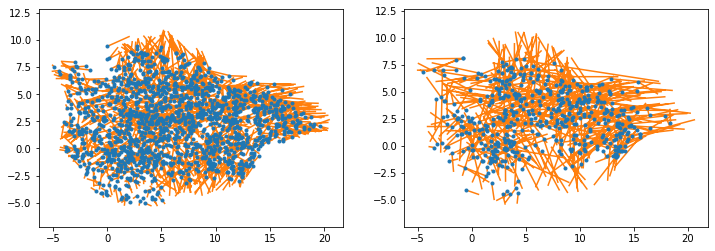

In [ ]:
plot_residuals(models[2].predict, dataset)

MLPRegressor(max_iter=1000, random_state=1)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'train': {'rsq': 0.9083137965391206, 'rmse': 1.3293471825337502}, 'test': {'rsq': 0.7910882955444848, 'rmse': 2.1096504869844788}}


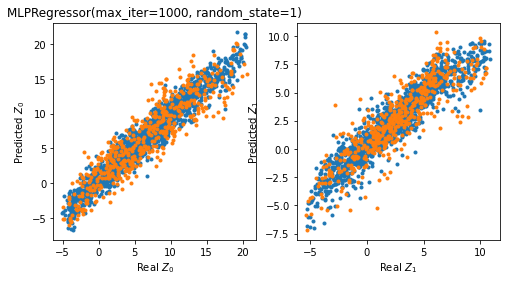

In [ ]:
from sklearn import neural_network

nn_models = [neural_network.MLPRegressor(random_state=1, max_iter=1000)]  # Deb's code

for model in nn_models:
    print(model)
    metrics = train_evaluate_model(model, dataset)
    print(metrics)

for model in nn_models:
    plot_parity(model.predict, dataset, name=str(model))           

MLPRegressor(alpha=0, hidden_layer_sizes=50, max_iter=1000, random_state=0)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'train': {'rsq': 0.8503317100382051, 'rmse': 1.7475052024377506}, 'test': {'rsq': 0.7600109251567875, 'rmse': 2.2592314746222946}}
MLPRegressor(alpha=0, hidden_layer_sizes=(25, 25), max_iter=1000,
             random_state=0)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'train': {'rsq': 0.8798895743023266, 'rmse': 1.526126013004617}, 'test': {'rsq': 0.7688223694981631, 'rmse': 2.246376618843043}}
MLPRegressor(alpha=0, hidden_layer_sizes=(17, 17, 16), max_iter=1000,
             random_state=0)
{'train': {'rsq': 0.8690528584995107, 'rmse': 1.6153361609094945}, 'test': {'rsq': 0.7795451089555567, 'rmse': 2.223533576557963}}
MLPRegressor(alpha=0, hidden_layer_sizes=(13, 13, 12, 12), max_iter=1000,
             random_state=0)
{'train': {'rsq': 0.8550564604539415, 'rmse': 1.7072092646593753}, 'test': {'rsq': 0.7908122399084754, 'rmse': 2.1084819504006234}}
MLPRegressor(alpha=0, hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000,
             random_state=0)
{'train': {'rsq': 0.8537464127210781, 'rmse': 1.753529013823103}, 'test': {'rsq': 0.7543725303138289, 'rmse': 2.3240964439467837}}


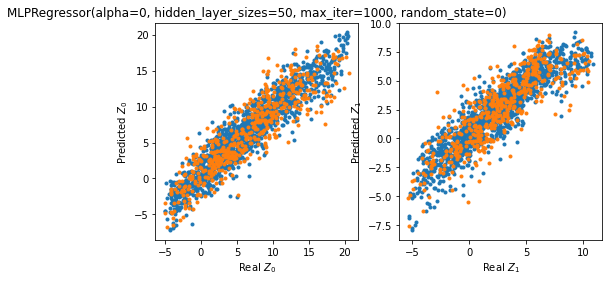

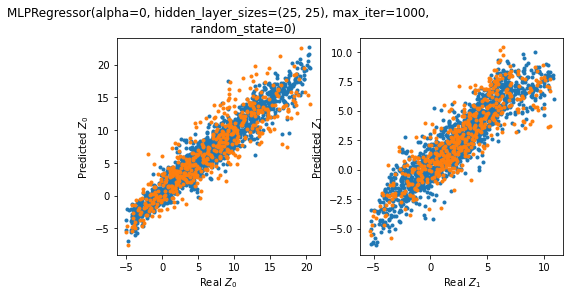

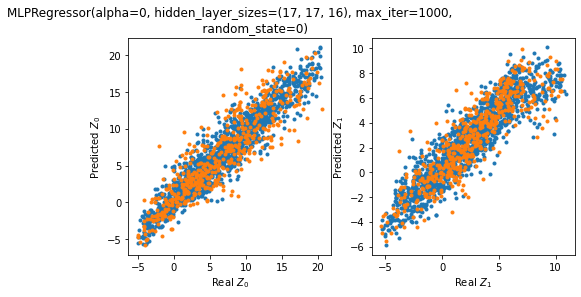

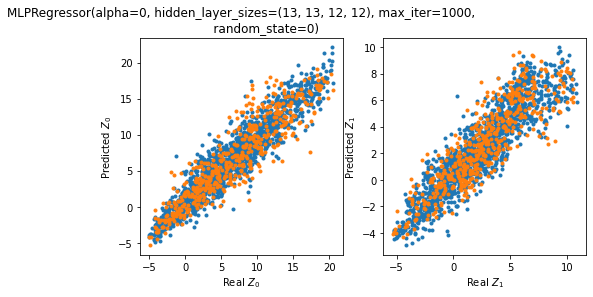

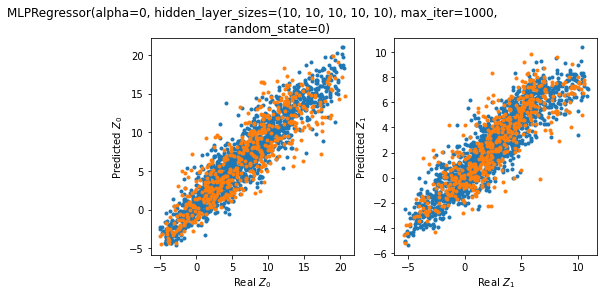

In [ ]:
from sklearn import neural_network

kwargs = dict(random_state=0, max_iter=1000, alpha=0)

nn_models = [neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(50)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(25, 25)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(17, 17, 16)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(13, 13, 12, 12)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(10, 10, 10, 10, 10)),
             ]

for model in nn_models:
    print(model)
    metrics = train_evaluate_model(model, dataset)
    print(metrics)

for model in nn_models:
    plot_parity(model.predict, dataset, name=str(model))                 

In [ ]:
plot_residuals(nn_models[2].predict, reverse=False)
plot_residuals(nn_models[2].predict, reverse=True)

TypeError: ignored

# regression on bag of words

In [ ]:
import itertools
import tqdm.notebook
from math import factorial

def swap_monomers(seq):
    seq = seq.replace('A', 'C')
    seq = seq.replace('B', 'A')
    seq = seq.replace('C', 'B')
    return seq

def make_base(degree):
    # construct unique numbers of A/B monomers
    base = []
    for i in range(degree+1):
        for j in range(i):
            seq = ''.join(['A' for _ in range(i-j)] + ['B' for _ in range(j)])
            # print((i, j), seq)
            base += [''.join(x) for x in itertools.permutations(seq)]
            base += [''.join(x) for x in itertools.permutations(swap_monomers(seq))]
    base = sorted(set(base))
    pruned_base = []
    for b in base:
        if b not in pruned_base and b[::-1] not in pruned_base:
            pruned_base.append(b)
    base = pruned_base
    print(f'Finding {len(base)} patterns:', base)

    return base

def featurize(chain_sequences, base):
    X = np.zeros([len(chain_sequences), len(base)])
    for i, chain in tqdm.notebook.tqdm(enumerate(chain_sequences), total=len(chain_sequences)):
        if 'A' in str(chain):
            seq = chain
        else:
            seq = ''.join(['A' if x == 0 else 'B' for x in chain])
        X[i] = 0.5 * (np.array([seq.count(b) for b in base]) + np.array([seq[::-1].count(b) for b in base]))
    return X

# this rescales the bar charts so long sequences appear equally likely
# prefactor = np.ones(len(base))
# prefactor = np.array([len(x) for x in base])
# prefactor = np.array([factorial(len(x)) / factorial(max(0, len(x)-1)) for x in base])

## raw numbers

In [ ]:
base = make_base(3)
print(len(base))

Finding 11 patterns: ['A', 'AA', 'AAA', 'AAB', 'AB', 'ABA', 'ABB', 'B', 'BAB', 'BB', 'BBB']
11


In [ ]:
from sklearn import model_selection

base = make_base(3)
prefactor = np.ones(len(base))

Xp = featurize(X, base)
print(Xp[:5])

dataset = model_selection.train_test_split(Xp, y, random_state=0)
Xtrain, Xtest, ytrain, ytest = dataset

Finding 11 patterns: ['A', 'AA', 'AAA', 'AAB', 'AB', 'ABA', 'ABB', 'B', 'BAB', 'BB', 'BBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

[[12.  6.  4.  1.  1.  0.  1.  8.  0.  4.  2.]
 [12.  5.  2.  2.  3.  1.  2.  8.  1.  3.  1.]
 [12.  4.  2.  1.  4.  1.  2.  8.  2.  3.  1.]
 [12.  5.  2.  2.  4.  2.  2.  8.  2.  2.  2.]
 [12.  4.  2.  1.  4.  1.  3.  8.  2.  3.  1.]]


In [ ]:
featurize([[0]*6+[1]*8+[0]*6], base)

  0%|          | 0/1 [00:00<?, ?it/s]

array([[12.,  6.,  4.,  1.,  1.,  0.,  1.,  8.,  0.,  4.,  2.]])

In [ ]:
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble

models = [linear_model.LinearRegression(),
          linear_model.Ridge(),
          neighbors.KNeighborsRegressor(),
          ensemble.RandomForestRegressor(random_state=0)]

for model in models:
    print(model)
    metrics = train_evaluate_model(model, dataset)
    print(metrics)

# for model in models:
#     plot_parity(model.predict, dataset, name=str(model))

LinearRegression()
{'train': {'rsq': 0.8302243515912533, 'rmse': 1.9810751222363732}, 'test': {'rsq': -2.439050069722479e+21, 'rmse': 263842587330.79852}}
Ridge()
{'train': {'rsq': 0.811020981135502, 'rmse': 2.084673371515912}, 'test': {'rsq': 0.7069124678451639, 'rmse': 2.541256038226851}}
KNeighborsRegressor()
{'train': {'rsq': 0.5804526095982979, 'rmse': 3.1838313003194414}, 'test': {'rsq': 0.36610646862117346, 'rmse': 3.89857198085007}}
RandomForestRegressor(random_state=0)
{'train': {'rsq': 0.9486499162353801, 'rmse': 1.0767713662979503}, 'test': {'rsq': 0.6326427307932694, 'rmse': 2.884138780922311}}


Finding 2 patterns: ['A', 'B']


  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': -7.562219971501971e-05, 'rmse': 4.724374750581212}, 'test': {'rsq': -0.0009234533523611033, 'rmse': 4.86530122933368}}
Finding 6 patterns: ['A', 'AA', 'AB', 'B', 'BA', 'BB']


  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.211820434651951, 'rmse': 4.151355639593262}, 'test': {'rsq': 0.1984336466823795, 'rmse': 4.33394415981555}}
Finding 14 patterns: ['A', 'AA', 'AAA', 'AAB', 'AB', 'ABA', 'ABB', 'B', 'BA', 'BAA', 'BAB', 'BB', 'BBA', 'BBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.40739160610174185, 'rmse': 3.653832971137717}, 'test': {'rsq': 0.38914906277051386, 'rmse': 3.8602910829449306}}
Finding 30 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAB', 'AAB', 'AABA', 'AABB', 'AB', 'ABA', 'ABAA', 'ABAB', 'ABB', 'ABBA', 'ABBB', 'B', 'BA', 'BAA', 'BAAA', 'BAAB', 'BAB', 'BABA', 'BABB', 'BB', 'BBA', 'BBAA', 'BBAB', 'BBB', 'BBBA', 'BBBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.5852016973623526, 'rmse': 3.021447235309114}, 'test': {'rsq': 0.5594919238944724, 'rmse': 3.205074925971347}}
Finding 62 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAB', 'AAAB', 'AAABA', 'AAABB', 'AAB', 'AABA', 'AABAA', 'AABAB', 'AABB', 'AABBA', 'AABBB', 'AB', 'ABA', 'ABAA', 'ABAAA', 'ABAAB', 'ABAB', 'ABABA', 'ABABB', 'ABB', 'ABBA', 'ABBAA', 'ABBAB', 'ABBB', 'ABBBA', 'ABBBB', 'B', 'BA', 'BAA', 'BAAA', 'BAAAA', 'BAAAB', 'BAAB', 'BAABA', 'BAABB', 'BAB', 'BABA', 'BABAA', 'BABAB', 'BABB', 'BABBA', 'BABBB', 'BB', 'BBA', 'BBAA', 'BBAAA', 'BBAAB', 'BBAB', 'BBABA', 'BBABB', 'BBB', 'BBBA', 'BBBAA', 'BBBAB', 'BBBB', 'BBBBA', 'BBBBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.7158957642256806, 'rmse': 2.441979466976177}, 'test': {'rsq': 0.6192966396937122, 'rmse': 2.9633713479597126}}
Finding 126 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAB', 'AAAAB', 'AAAABA', 'AAAABB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAB', 'AAABB', 'AAABBA', 'AAABBB', 'AAB', 'AABA', 'AABAA', 'AABAAA', 'AABAAB', 'AABAB', 'AABABA', 'AABABB', 'AABB', 'AABBA', 'AABBAA', 'AABBAB', 'AABBB', 'AABBBA', 'AABBBB', 'AB', 'ABA', 'ABAA', 'ABAAA', 'ABAAAA', 'ABAAAB', 'ABAAB', 'ABAABA', 'ABAABB', 'ABAB', 'ABABA', 'ABABAA', 'ABABAB', 'ABABB', 'ABABBA', 'ABABBB', 'ABB', 'ABBA', 'ABBAA', 'ABBAAA', 'ABBAAB', 'ABBAB', 'ABBABA', 'ABBABB', 'ABBB', 'ABBBA', 'ABBBAA', 'ABBBAB', 'ABBBB', 'ABBBBA', 'ABBBBB', 'B', 'BA', 'BAA', 'BAAA', 'BAAAA', 'BAAAAA', 'BAAAAB', 'BAAAB', 'BAAABA', 'BAAABB', 'BAAB', 'BAABA', 'BAABAA', 'BAABAB', 'BAABB', 'BAABBA', 'BAABBB', 'BAB', 'BABA', 'BABAA', 'BABAAA', 'BABAAB', 'BABAB', 'BABABA', 'BABABB', 'BABB'

  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.7744207074179821, 'rmse': 2.150715709671048}, 'test': {'rsq': 0.6543825142661935, 'rmse': 2.8315836416327795}}
Finding 254 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAB', 'AAAAAB', 'AAAAABA', 'AAAAABB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAB', 'AAAABB', 'AAAABBA', 'AAAABBB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAAA', 'AAABAAB', 'AAABAB', 'AAABABA', 'AAABABB', 'AAABB', 'AAABBA', 'AAABBAA', 'AAABBAB', 'AAABBB', 'AAABBBA', 'AAABBBB', 'AAB', 'AABA', 'AABAA', 'AABAAA', 'AABAAAA', 'AABAAAB', 'AABAAB', 'AABAABA', 'AABAABB', 'AABAB', 'AABABA', 'AABABAA', 'AABABAB', 'AABABB', 'AABABBA', 'AABABBB', 'AABB', 'AABBA', 'AABBAA', 'AABBAAA', 'AABBAAB', 'AABBAB', 'AABBABA', 'AABBABB', 'AABBB', 'AABBBA', 'AABBBAA', 'AABBBAB', 'AABBBB', 'AABBBBA', 'AABBBBB', 'AB', 'ABA', 'ABAA', 'ABAAA', 'ABAAAA', 'ABAAAAA', 'ABAAAAB', 'ABAAAB', 'ABAAABA', 'ABAAABB', 'ABAAB', 'ABAABA', 'ABAABAA', 'ABAABAB', 'ABAABB', 'ABAABBA', 'ABAA

  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.9600019027359512, 'rmse': 0.8275659393114457}, 'test': {'rsq': 0.671835381875937, 'rmse': 2.747018150307239}}
Finding 510 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAAA', 'AAAAAAAB', 'AAAAAAB', 'AAAAAABA', 'AAAAAABB', 'AAAAAB', 'AAAAABA', 'AAAAABAA', 'AAAAABAB', 'AAAAABB', 'AAAAABBA', 'AAAAABBB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAAA', 'AAAABAAB', 'AAAABAB', 'AAAABABA', 'AAAABABB', 'AAAABB', 'AAAABBA', 'AAAABBAA', 'AAAABBAB', 'AAAABBB', 'AAAABBBA', 'AAAABBBB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAAA', 'AAABAAAA', 'AAABAAAB', 'AAABAAB', 'AAABAABA', 'AAABAABB', 'AAABAB', 'AAABABA', 'AAABABAA', 'AAABABAB', 'AAABABB', 'AAABABBA', 'AAABABBB', 'AAABB', 'AAABBA', 'AAABBAA', 'AAABBAAA', 'AAABBAAB', 'AAABBAB', 'AAABBABA', 'AAABBABB', 'AAABBB', 'AAABBBA', 'AAABBBAA', 'AAABBBAB', 'AAABBBB', 'AAABBBBA', 'AAABBBBB', 'AAB', 'AABA', 'AABAA', 'AABAAA', 'AABAAAA', 'AABAAAAA', 'AABAAAAB', 'AABAAAB', 'AABAAABA', '

  0%|          | 0/2038 [00:00<?, ?it/s]

MLPRegressor(max_iter=1000, random_state=1)
{'train': {'rsq': 0.989126742482305, 'rmse': 0.43423895651960814}, 'test': {'rsq': 0.6493070473506681, 'rmse': 2.765647486694431}}


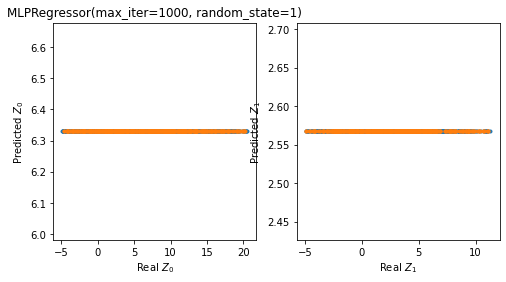

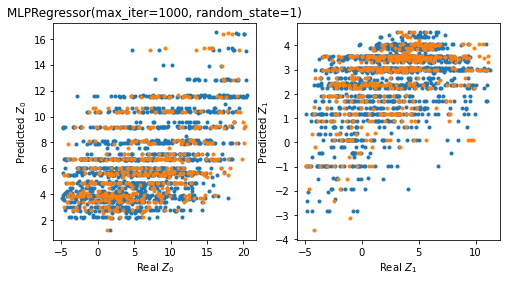

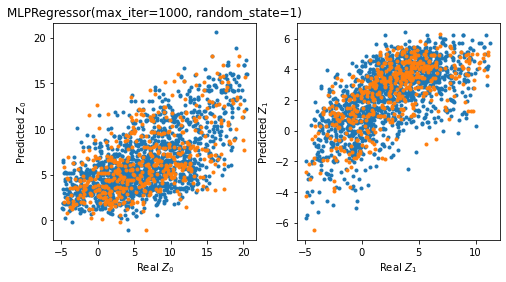

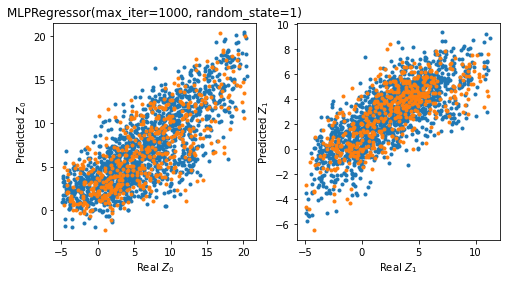

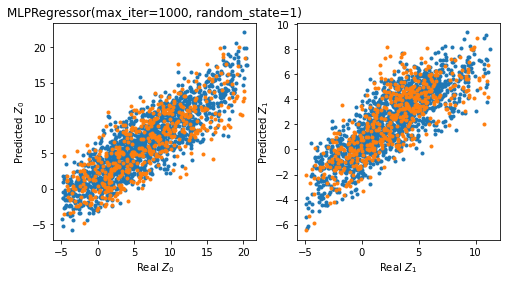

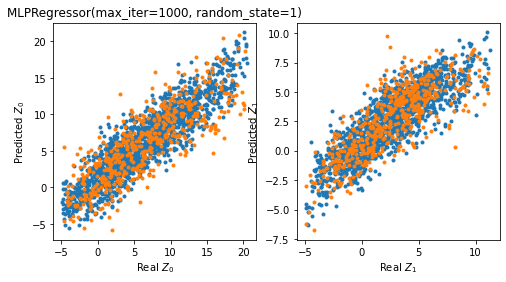

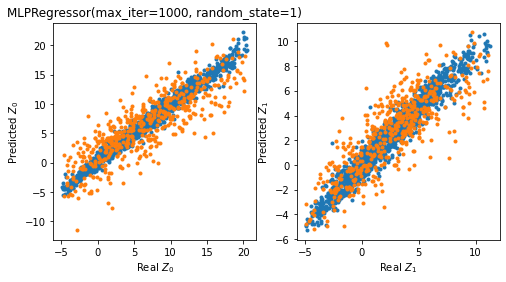

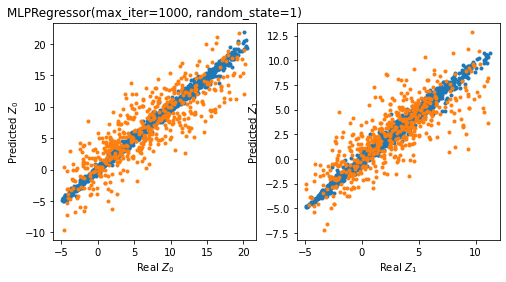

In [ ]:
from sklearn import neural_network
from sklearn import model_selection

mlp_metrics = {}

for i in range(2, 10):

    base = make_base(i)
    prefactor = np.ones(len(base))

    Xp = featurize(X, base)

    dataset = model_selection.train_test_split(Xp, y, random_state=0)
    Xtrain, Xtest, ytrain, ytest = dataset

    nn_models = [neural_network.MLPRegressor(random_state=1, max_iter=1000)]  # Deb's code

    for model in nn_models:
        print(model)
        metrics = train_evaluate_model(model, dataset)
        print(metrics)

    for model in nn_models:
        plot_parity(model.predict, dataset, name=str(model))
    
    mlp_metrics[i] = metrics

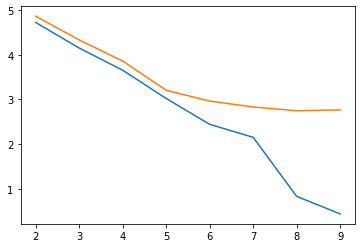

In [ ]:
pattern_L = sorted(mlp_metrics.keys())
for x in ['train', 'test']:
    rmse = [mlp_metrics[l][x]['rmse'] for l in pattern_L]
    plt.plot(pattern_L, rmse, '-')

In [ ]:
def k_fold_cross_val(X,y,splits):
  cv = KFold(n_splits=splits, random_state=1, shuffle=True)
  Xy_train=[]
  Xy_test=[]
  X_train=[]
  X_test=[]
  y_test=[]
  y_train=[]
  for train, test in cv.split(np.hstack((X,y))):
    Xy_train.append(np.hstack((X,y))[train])
    Xy_test.append(np.hstack((X,y))[test])
  for xy_tr in Xy_train:
    X_train.append(xy_tr[:,:-2])
    y_train.append(xy_tr[:,-2:])
  for xy_te in Xy_test:
    X_test.append(xy_tr[:,:-2])
    y_test.append(xy_tr[:,-2:])
  return X_train,X_test,y_train,y_test

<generator object _BaseKFold.split at 0x7fad585bbd50>

In [ ]:
from sklearn.model_selection import KFold

from sklearn import neural_network
from sklearn import model_selection

mlp_metrics = {}

n_splits = 4
cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)

for i in [8]:

    base = make_base(i)
    prefactor = np.ones(len(base))

    Xp = featurize(X, base)

    # dataset = model_selection.train_test_split(Xp, y, random_state=0)
    # Xtrain, Xtest, ytrain, ytest = dataset

    for k, idx in enumerate(cv.split(Xp, y)):
        train_idx, test_idx = idx
        
        dataset = (Xp[train_idx], Xp[test_idx], y[train_idx], y[test_idx])

        model = neural_network.MLPRegressor(random_state=1, max_iter=1000)  # from Deb's code
        metrics = train_evaluate_model(model, dataset)
        print(metrics)
        
        mlp_metrics[k] = metrics

Finding 254 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAB', 'AAAAAB', 'AAAAABA', 'AAAAABB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAB', 'AAAABB', 'AAAABBA', 'AAAABBB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAAA', 'AAABAAB', 'AAABAB', 'AAABABA', 'AAABABB', 'AAABB', 'AAABBA', 'AAABBAA', 'AAABBAB', 'AAABBB', 'AAABBBA', 'AAABBBB', 'AAB', 'AABA', 'AABAA', 'AABAAA', 'AABAAAA', 'AABAAAB', 'AABAAB', 'AABAABA', 'AABAABB', 'AABAB', 'AABABA', 'AABABAA', 'AABABAB', 'AABABB', 'AABABBA', 'AABABBB', 'AABB', 'AABBA', 'AABBAA', 'AABBAAA', 'AABBAAB', 'AABBAB', 'AABBABA', 'AABBABB', 'AABBB', 'AABBBA', 'AABBBAA', 'AABBBAB', 'AABBBB', 'AABBBBA', 'AABBBBB', 'AB', 'ABA', 'ABAA', 'ABAAA', 'ABAAAA', 'ABAAAAA', 'ABAAAAB', 'ABAAAB', 'ABAAABA', 'ABAAABB', 'ABAAB', 'ABAABA', 'ABAABAA', 'ABAABAB', 'ABAABB', 'ABAABBA', 'ABAABBB', 'ABAB', 'ABABA', 'ABABAA', 'ABABAAA', 'ABABAAB', 'ABABAB', 'ABABABA', 'ABABABB', 'ABABB', 'ABABBA', 'ABABBAA', 'ABABBAB', 'ABABBB', 'ABABBBA', 'ABABBBB', 'ABB', 'ABBA', 

  0%|          | 0/2038 [00:00<?, ?it/s]

{'train': {'rsq': 0.9312608903668563, 'rmse': 1.1665793712454753}, 'test': {'rsq': 0.6857958231735004, 'rmse': 2.61410468889533}}
{'train': {'rsq': 0.9126099261777189, 'rmse': 1.3306666667411489}, 'test': {'rsq': 0.6954397444732247, 'rmse': 2.5533126621435183}}
{'train': {'rsq': 0.9650195212442993, 'rmse': 0.7681068963614188}, 'test': {'rsq': 0.6541571489957483, 'rmse': 2.7985934318800116}}
{'train': {'rsq': 0.9566216047384455, 'rmse': 0.8759568457125183}, 'test': {'rsq': 0.6541564959843604, 'rmse': 2.6216229353943254}}


In [ ]:
from sklearn import neural_network

kwargs = dict(random_state=0, max_iter=1000, alpha=0)

nn_models = [neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(50)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(25, 25)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(17, 17, 16)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(13, 13, 12, 12)),
             neural_network.MLPRegressor(**kwargs, hidden_layer_sizes=(10, 10, 10, 10, 10)),
             ]

for model in nn_models:
    print(model)
    metrics = train_evaluate_model(model, dataset)
    print(metrics)

MLPRegressor(alpha=0, hidden_layer_sizes=50, max_iter=1000, random_state=0)
{'train': {'rsq': 0.6882817925542744, 'rmse': 6.739779795591691}, 'test': {'rsq': 0.6426447500526048, 'rmse': 8.473592101358017}}
MLPRegressor(alpha=0, hidden_layer_sizes=(25, 25), max_iter=1000,
             random_state=0)
{'train': {'rsq': 0.8128766277021373, 'rmse': 3.643228795603355}, 'test': {'rsq': 0.6618362279084015, 'rmse': 7.999246456814536}}
MLPRegressor(alpha=0, hidden_layer_sizes=(17, 17, 16), max_iter=1000,
             random_state=0)
{'train': {'rsq': 0.7577178102978452, 'rmse': 4.849149611578541}, 'test': {'rsq': 0.6582301754737534, 'rmse': 8.03688300722349}}
MLPRegressor(alpha=0, hidden_layer_sizes=(13, 13, 12, 12), max_iter=1000,
             random_state=0)
{'train': {'rsq': 0.7168309941572197, 'rmse': 5.79666441107098}, 'test': {'rsq': 0.6429691493076678, 'rmse': 8.384342042457236}}
MLPRegressor(alpha=0, hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000,
             random_state=0)
{'

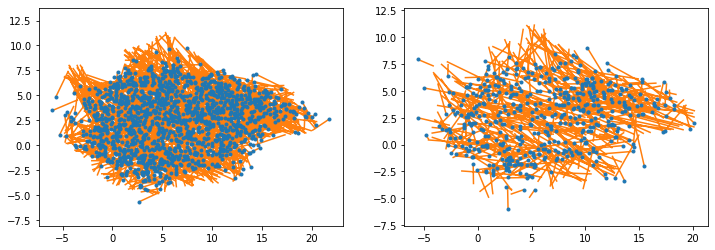

In [ ]:
plot_residuals(nn_models[2].predict, dataset, reverse=False)

## standard scaler

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(Xtrain)

dataset[0] = scaler.transform(Xtrain)
dataset[1] = scaler.transform(Xtest)

Xtrain, Xtest, ytrain, ytest = dataset

In [ ]:
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble

models = [linear_model.LinearRegression(),
          neighbors.KNeighborsRegressor(),
          ensemble.RandomForestRegressor(random_state=0)]

for model in models:
    print(model)
    metrics = train_evaluate_model(model, dataset)
    print(metrics)

LinearRegression()
{'train': {'rsq': 0.3649907601845579, 'rmse': 14.588422947245812}, 'test': {'rsq': 0.38075011342286574, 'rmse': 15.451588720508786}}
KNeighborsRegressor()
{'train': {'rsq': 0.56445998368284, 'rmse': 9.523039007920413}, 'test': {'rsq': 0.3709532542909685, 'rmse': 14.351002390168718}}
RandomForestRegressor(random_state=0)
{'train': {'rsq': 0.7758379197550627, 'rmse': 4.938276433355318}, 'test': {'rsq': 0.43711591653705884, 'rmse': 12.847568844630018}}


# 2d residual plot

In [ ]:
from sklearn import model_selection

def get_test_set(dataset, constructor, verbose=False):

  try:
    constructor, args, kwargs = constructor
  except IndexError:
    # catch the case of not providing explicit args or kwargs
    args = []
    kwargs = {}

  X, y, flip = dataset

  kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

  gt = np.zeros([0, 2])
  pred = np.zeros([0, 2])

  metrics = []

  for i, test_train in enumerate(kf.split(X)):
    if verbose:
      print(f'Training fold {i}...')
      train_index, test_index = test_train

      # set up the fold
      trainX, testX = X[train_index], X[test_index]
      trainy, testy = y[train_index], y[test_index]

      # train the model on this fold
      model = constructor(*args, **kwargs)
      if flip:
        model.fit(np.vstack([trainX, np.fliplr(trainX)]), np.vstack([trainy, trainy]))
      else:
        model.fit(trainX, trainy)

      #
      fold_metrics = {}

      for name, thisX, thisy in [('train', trainX, trainy),
                                ('test', testX, testy)]:
        # get prediction
        fwd = model.predict(thisX)
        if flip:
          rev = model.predict(np.fliplr(thisX))
          ypred = 0.5*(fwd+rev)
        else:
          ypred = fwd
        # compute metrics
        residual = ypred - thisy
        rmse = np.sqrt(np.mean(residual**2))
        rsq = 1 - np.var(residual) / np.var(thisy)
        adj_rsq = 1 - ( 1-rsq ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )
        # store results for train/test loop
        fold_metrics[name] = {'rsq': rsq, 'adj_rsq': adj_rsq, 'rmse': rmse}
      
      # store results for cross validation loop
      metrics.append(fold_metrics)
      
      # compute prediction
      fwd = model.predict(testX)
      if flip:
        rev = model.predict(np.fliplr(testX))
        ypred = 0.5*(fwd+rev)
      else:
        ypred = fwd

      # store the test data from this fold
      pred = np.vstack([pred, ypred])
      gt = np.vstack([gt, testy])
    
  return gt, pred, metrics

In [ ]:
dataset = (X, y, True)

In [ ]:
base = make_base(3)
prefactor = np.ones(len(base))
Xp = featurize(X, base)
dataset = (Xp, y, False)

NameError: ignored

In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import colors
import matplotlib.tri as tri

from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network
import joblib, os


def draw_res(gt, pred, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(3.54, 3.54))
  else:
    fig = ax.figure

  for i in range(2):
      ax.plot(pred[:, i], gt[:, i], '.', alpha=0.5, label='$Z_%d$' % i)
  ax.plot([-6, 22], [-6, 22], 'k-', zorder=10, label='Parity')
  ax.legend()
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Observed')

  return fig


def draw_kde(gt, pred, lim=8, res=2, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(3.54, 3.54))
  else:
    fig = ax.figure
  
  err = np.vstack([pred[:, 0]-gt[:, 0], pred[:, 1]-gt[:, 1]]).T
  ext = np.ceil(np.abs(err).max())

  # lim = 8
  # res = 2
  xl = np.arange(-ext, ext, 1/res)
  yl = np.arange(-ext, ext, 1/res)
  xg, yg = np.meshgrid(xl, yl)
  xg = xg.flatten()
  yg = yg.flatten()

  xytri = tri.Triangulation(xg, yg)

  xyg = np.vstack([xg, yg]).T

  kernel = gaussian_kde(err.T, bw_method=0.20)
  zg = kernel(xyg.T)
  im = ax.tricontourf(xytri, zg, cmap='Blues')#, levels=np.linspace(-3,0,13))
  ax.set_aspect('equal')#, 'datalim')
  cb = plt.colorbar(im)
  cb.set_label('$P(\Delta Z_0, \Delta Z_1)$')
  #
  ax.plot(np.zeros(2), [-lim, lim], 'k--')
  ax.plot([-lim, lim], np.zeros(2), 'k--')
  #
  ax.set_xlim(-lim, lim)
  ax.set_xticks(np.arange(-lim, lim))
  ax.set_ylim(-lim, lim)
  ax.set_yticks(np.arange(-lim, lim))
  #
  ax.set_xlabel('$\Delta Z_0$')
  ax.set_ylabel('$\Delta Z_1$')
  
  return fig

## run sequence vectors

In [ ]:
# define model constructor to evaluate 
constructors = [(linear_model.LinearRegression, [], dict()),
                (linear_model.Lasso, [], dict()),
                (linear_model.Ridge, [], dict()),
                (neighbors.KNeighborsRegressor, [], dict()),
                # TODO: GaussianProcess
                (ensemble.RandomForestRegressor, [], dict(random_state=0)),
                (neural_network.MLPRegressor, [], dict(random_state=0)),
                # TODO: MLP of different dimensions
]

dataset = (X, y, True)
all_evals = {}
for c in constructors:
  print(f'evaluating {c[0]}')
  # compute result
  all_evals[str(c[0])] = get_test_set(dataset, *c)
# save results
# joblib.dump(all_evals, os.path.join(drive_prefix, 'models', 'metrics-sequence.jbl'))

evaluating <class 'sklearn.linear_model._base.LinearRegression'>
evaluating <class 'sklearn.linear_model._coordinate_descent.Lasso'>
evaluating <class 'sklearn.linear_model._ridge.Ridge'>
evaluating <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
evaluating <class 'sklearn.ensemble._forest.RandomForestRegressor'>
evaluating <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

['/content/drive/Shareddrives/Polymers-Data/models/metrics-sequence.jbl']

## run n-grams

In [ ]:
# define model constructor to evaluate 
constructors = [(linear_model.LinearRegression, [], dict()),
                (linear_model.Lasso, [], dict()),
                (linear_model.Ridge, [], dict()),
                (neighbors.KNeighborsRegressor, [], dict()),
                # TODO: GaussianProcess
                (ensemble.RandomForestRegressor, [], dict(random_state=0)),
                (neural_network.MLPRegressor, [], dict(max_iter=1000,random_state=0)),
                # TODO: MLP of different dimensions
]
# constructor = ensemble.RandomForestRegressor
# constructor = neighbors.KNeighborsRegressor
for L in range(1, 11):
  base = make_base(L)
  prefactor = np.ones(len(base))
  Xp = featurize(X, base)
  dataset = (Xp, y, False)
  # reset data
  all_evals = {}
  for c in constructors:
    print(f'evaluating {c[0]}')
    # compute result
    all_evals[str(c[0])] = get_test_set(dataset, *c)
  # save results
  # joblib.dump(all_evals, os.path.join(drive_prefix, 'models', f'metrics-L{L}.jbl'))

## run MLP specifically

In [ ]:
# define model constructor to evaluate 
constructors = [(neural_network.MLPRegressor, [], dict(max_iter=1000, random_state=0, learning_rate='adaptive', hidden_layer_sizes=(32, 16, 8, 4))),
                # TODO: MLP of different dimensions
]

# load previous results from file
all_evals = joblib.load(os.path.join(drive_prefix, 'models', 'metrics-sequence.jbl'))

dataset = (X, y, True)

for c in constructors:
  print(f'evaluating {c[0]}')
  # compute result
  all_evals[str(c[0])] = get_test_set(dataset, c, verbose=True)
# save results
# joblib.dump(all_evals, os.path.join(drive_prefix, 'models', 'metrics-sequence.jbl'))

evaluating <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
Training fold 0...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...


['/content/drive/Shareddrives/Polymers-Data/models/metrics-sequence.jbl']

# run lstm from file

In [ ]:
import torch
from torch import nn
import glob
import os
from google.colab import drive
import numpy as np


drive.mount('/content/drive')
drive_prefix = '/content/drive/Shareddrives/Polymers-Data'


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim,
            batch_first=True, dropout=dropout_prob,
            bidirectional=True
        )

        # 2x for bidirectional LSTM
        self.dense = nn.Linear(2 * hidden_dim, output_dim)

    def embed(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim,
                         device=device).requires_grad_()
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim,
                         device=device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # concatenate the bidirectional output
        out = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)

        return out        

    def forward(self, x):
        out = self.embed(x)
        out = self.dense(out)

        return out


models_on_disk = sorted(glob.glob(os.path.join(drive_prefix, 'models', 'lstm-cv10-*.pt')))
trained_models = []
for i, fp in enumerate(models_on_disk):
    model = torch.load(fp, map_location=torch.device('cpu'))
    # model = LSTMModel()
    # model.load_state_dict(torch.load(fp))
    trained_models.append(model)

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)
print(f'working on {device}')


def predict_lstm(X, return_sigma=False):
    """Takes X as numpy array and returns y as numpy array.
    * converts to torch tensor,
    * averages forward and reverse copies of sequences,
    * repeats for each model in the cross-fold validation,
    * returns average and standard deviation from cross-fold validation
    """
    X = torch.Tensor(X).unsqueeze(2).to(device)
    y = []
    for model in trained_models:
        fwd = model(X)
        rev = model(torch.fliplr(X))
        avg = 0.5 * (fwd + rev)
        y.append(avg.to('cpu').detach().numpy())
    # average over folds
    mu = np.mean(y, axis=0)
    if return_sigma:
        # return standard deviation over folds
        sigma = np.std(y, axis=0)
        return mu, sigma
    else:
        return mu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
working on cpu


In [ ]:
from sklearn import model_selection

def get_test_set_lstm(X, y, verbose=False):

  X = torch.Tensor(X).unsqueeze(2).to(device)
  y = torch.Tensor(y).to(device)

  kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

  gt = np.zeros([0, 2])
  pred = np.zeros([0, 2])

  metrics = []

  for i, test_train in enumerate(kf.split(X)):
    train_index, test_index = test_train

    # set up the fold
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]

    # train the model on this fold
    model = trained_models[i]

    #
    fold_metrics = {}

    for name, thisX, thisy in [('train', trainX, trainy),
                            ('test', testX, testy)]:
        # get prediction
        fwd = model(thisX)
        rev = model(torch.fliplr(thisX))
        ypred = 0.5*(fwd+rev).to('cpu').detach().numpy()

        # compute metrics
        thisy = thisy.to('cpu').detach().numpy()
        residual = ypred - thisy
        rmse = np.sqrt(np.mean(residual**2))
        rsq = 1 - np.var(residual) / np.var(thisy)
        adj_rsq = 1 - ( 1-rsq ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )
        # store results for train/test loop
        fold_metrics[name] = {'rsq': rsq, 'adj_rsq': adj_rsq, 'rmse': rmse}
        
        # store results for cross validation loop
        metrics.append(fold_metrics)
    
    # get prediction
    fwd = model(testX)
    rev = model(torch.fliplr(testX))
    ypred = 0.5*(fwd+rev).to('cpu').detach().numpy()

    # store the test data from this fold
    pred = np.vstack([pred, ypred])
    gt = np.vstack([gt, testy])

  return gt, pred, metrics

lstm_result = get_test_set_lstm(X, y)

## evaluate results

In [ ]:
import joblib, os
# load from file
all_evals = joblib.load(os.path.join(drive_prefix, 'models', 'metrics-sequence.jbl'))

In [ ]:
def draw_isoring(gt, pred, lim=8, res=2, ax=None, color_code=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(3.54, 3.54))
  else:
    fig = ax.figure
  
  err = np.vstack([pred[:, 0]-gt[:, 0], pred[:, 1]-gt[:, 1]]).T
  ext = np.ceil(np.abs(err).max())

  # lim = 8
  # res = 2
  xl = np.arange(-ext, ext, 1/res)
  yl = np.arange(-ext, ext, 1/res)
  xg, yg = np.meshgrid(xl, yl)
  xg = xg.flatten()
  yg = yg.flatten()

  xytri = tri.Triangulation(xg, yg)

  xyg = np.vstack([xg, yg]).T

  kernel = gaussian_kde(err.T, bw_method=0.20)
  zg = kernel(xyg.T)
  level_50 = np.sort(zg)[np.argmin(np.abs(np.cumsum(np.sort(zg))/np.sum(zg)-0.50))]
  # level_75 = np.sort(zg)[np.argmin(np.abs(np.cumsum(np.sort(zg))/np.sum(zg)-0.67))]
  im = ax.tricontour(xytri, zg, levels=[0, level_50], colors=[color_code, color_code])
  
  return im

In [ ]:
all_evals.keys()

dict_keys(["<class 'sklearn.linear_model._base.LinearRegression'>", "<class 'sklearn.linear_model._coordinate_descent.Lasso'>", "<class 'sklearn.linear_model._ridge.Ridge'>", "<class 'sklearn.neighbors._regression.KNeighborsRegressor'>", "<class 'sklearn.ensemble._forest.RandomForestRegressor'>", "<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>"])

In [ ]:
best = {}
t = 'rmse'
for s in ['test', 'train']:
  best[s] = {}
  for i, key in enumerate(all_evals.keys()):
    mu = [np.mean([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    sigma = [np.std([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    if s == 'test':
      idx = np.argmin(mu)
    else:
      idx = best['test'][key][0]
    best[s][key] = (idx, mu[idx], sigma[idx])
# make the chart
keys = list(best['test'].keys())
best_variant = {}
for i, k in enumerate(keys):
  b = best['test'][k][0]
  best_variant[k] = b
print(best_variant)

NameError: ignored

In [ ]:
best_metrics = {}
for key, L in best_variant.items():
  if L == 0:
    all_evals = joblib.load(os.path.join(drive_prefix, 'models', f'metrics-sequence.jbl'))
  else:
    all_evals = joblib.load(os.path.join(drive_prefix, 'models', f'metrics-L{L}.jbl'))
  best_metrics[key] = all_evals[key]

<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>


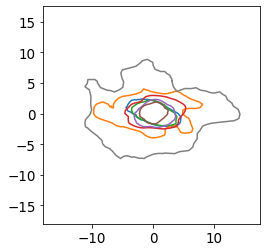

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots()
ax.plot(*(hull-np.array(alpha_shape.centroid.coords)).T, color=np.ones(3)*0.5)
ax.set_aspect('equal')
curves = {}
for i, this_key in enumerate(['Linear', 'Lasso', 'Ridge', 'KNeighbors', 'RandomForest', 'MLP']):
  key = [x for x in best_metrics.keys() if this_key in x][0]
  print(key)
  gt, pred, metrics = best_metrics[key]
  im = draw_isoring(gt, pred, ax=ax, color_code=cm.tab10(i))
  v = im.collections[-1].get_paths()[0].vertices
  # w = im.collections[-2].get_paths()[0].vertices
  curves[this_key] = [v]

In [ ]:
gt, pred, metrics = lstm_result
im = draw_isoring(gt, pred, ax=ax, color_code=cm.tab10(i))
v = im.collections[-1].get_paths()[0].vertices
# w = im.collections[-2].get_paths()[0].vertices
curves['LSTM'] = [v]

In [ ]:
import matplotlib
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 9*sc                   # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

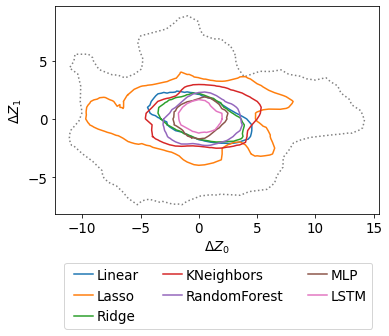

In [ ]:
fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
ax.plot(*(hull-np.array(alpha_shape.centroid.coords)).T, color=np.ones(3)*0.5, ls=':')
ax.set_aspect('equal')
i = 0
for k, v in curves.items():
    ax.plot(*v[0].T, label=k, color=cm.tab10(i), alpha=1.0)
    # ax.plot(*v[1].T, alpha=0.20, color=cm.tab10(i))
    i += 1
ax.legend(ncol=3, numpoints=3, handletextpad=0, columnspacing=1.5, loc='upper right', bbox_to_anchor=(1.0, -0.2))
ax.set_xlabel('$\Delta Z_0$')
ax.set_ylabel('$\Delta Z_1$')
fig.tight_layout(pad=0.25)
fig.savefig('residuals.pdf', bbox_inches='tight', pad_inches=0.05)

<class 'sklearn.linear_model._base.LinearRegression'>
train
rmse      : 4.154 +/- 0.016
rsq       : 0.346 +/- 0.003
adj_rsq   : 0.339 +/- 0.003
test
rmse      : 4.169 +/- 0.139
rsq       : 0.340 +/- 0.028
adj_rsq   : 0.334 +/- 0.029
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
train
rmse      : 0.965 +/- 0.005
rsq       : 0.965 +/- 0.001
adj_rsq   : 0.964 +/- 0.001
test
rmse      : 2.592 +/- 0.058
rsq       : 0.744 +/- 0.017
adj_rsq   : 0.742 +/- 0.017
<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
train
rmse      : 1.451 +/- 0.036
rsq       : 0.920 +/- 0.004
adj_rsq   : 0.920 +/- 0.004
test
rmse      : 1.794 +/- 0.105
rsq       : 0.877 +/- 0.017
adj_rsq   : 0.876 +/- 0.017


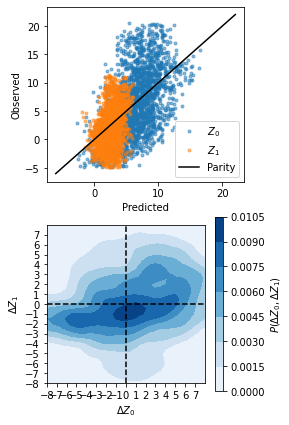

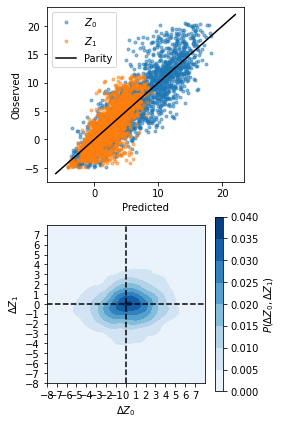

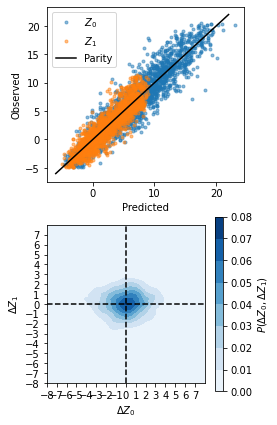

In [ ]:
for this_key in ['Linear', 'Forest', 'MLP']:
  key = [x for x in all_evals.keys() if this_key in x][0]
  print(key)
  gt, pred, metrics = all_evals[key]

  # print summary metrics
  for s in ['train', 'test']:
    print(s)
    for i, k in enumerate(['rmse', 'rsq', 'adj_rsq']):
      mu = np.mean([m[s][k] for m in metrics])
      sigma = np.std([m[s][k] for m in metrics])
      print(f'{k:10s}: {mu:.3f} +/- {sigma:.3f}')
  # draw figures
  fig, axes = plt.subplots(2, 1, figsize=(3.54, 3.54*2))
  fig = draw_res(gt, pred, ax=axes[0])
  fig = draw_kde(gt, pred, ax=axes[1])
  fig.savefig(f'parity-{this_key}.pdf')

### updated residual figure formatting

In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import colors
import matplotlib.tri as tri

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network
import joblib, os


def draw_res(gt, pred, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(3.54, 3.54))
  else:
    fig = ax.figure

  for i in range(2):
      ax.plot(pred[:, i], gt[:, i], '.', alpha=0.5, label='$Z_%d$' % i)
  ax.plot([-6, 22], [-6, 22], 'k-', zorder=10, label='Parity')
  ax.set_aspect('equal')
  ax.legend(loc='lower right')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Observed')

  return fig


def draw_kde(gt, pred, lim=8, res=2, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(3.54, 3.54))
  else:
    fig = ax.figure
  
  err = np.vstack([pred[:, 0]-gt[:, 0], pred[:, 1]-gt[:, 1]]).T
  ext = np.ceil(np.abs(err).max())

  # lim = 8
  # res = 2
  xl = np.arange(-ext, ext+1/res, 1/res)
  yl = np.arange(-ext, ext+1/res, 1/res)
  xg, yg = np.meshgrid(xl, yl)
  xg = xg.flatten()
  yg = yg.flatten()

  xytri = tri.Triangulation(xg, yg)

  xyg = np.vstack([xg, yg]).T

  kernel = gaussian_kde(err.T, bw_method=0.20)
  zg = kernel(xyg.T)
  im = ax.tricontourf(xytri, zg, cmap='Blues')#, levels=np.linspace(-3,0,13))
  ax.set_aspect('equal')#, 'datalim')
#   divider = make_axes_locatable(ax)
#   cax = divider.new_vertical(size="5%", pad=0.5, pack_start=True)
#   fig.add_axes(cax)
#   cb = fig.colorbar(im, cax=cax, orientation="horizontal")
#   cb = plt.colorbar(im, orientation="horizontal")
  cb = plt.colorbar(im)
  # cb.set_label('$P(\Delta Z_0, \Delta Z_1)$')
  ax.text(11.0, -10.5, '$P(\Delta Z_0, \Delta Z_1)$', ha='center')
  #
  ax.plot(np.zeros(2), [-lim, lim], 'k-', lw=1.0, color=np.ones(3)*0.33, alpha=0.33)
  ax.plot([-lim, lim], np.zeros(2), 'k-', lw=1.0, color=np.ones(3)*0.33, alpha=0.33)
  #
  ax.set_xlim(-lim, lim)
  ax.set_xticks(np.arange(-lim, lim+0.1, 2))
  ax.set_ylim(-lim, lim)
  ax.set_yticks(np.arange(-lim, lim+0.1, 2))
  #
  ax.set_xlabel('$\Delta Z_0$', labelpad=0)
  ax.set_ylabel('$\Delta Z_1$', labelpad=-6)
  ax.grid('on', color=np.ones(3)*0.33, alpha=0.167)

  return fig


fig, axes = plt.subplots(2, 1, figsize=(3.54, 3.54*2-1.5))
fig = draw_res(gt, pred, ax=axes[0])
fig = draw_kde(gt, pred, ax=axes[1])
fig.tight_layout()
fig.text(0, 0.95, '(a)')
fig.text(0, 0.475, '(b)')
fig.savefig(f'parity-lstm.pdf')

## write the table in latex format

In [ ]:
for i, key in enumerate(all_evals.keys()):
  short_key = key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "")
  print(short_key, '&', end=' ')
  for t in ['rmse', 'rsq']:
    for s in ['train', 'test']:
      mu = np.mean([m[s][t] for m in model_metrics[0][key]])
      sigma = np.std([m[s][t] for m in model_metrics[0][key]])
      digits = -int(f'{sigma:.1e}'.split('e')[1])+1
      print(np.round(mu, digits), '$\pm$', np.round(sigma, digits), end=' & ')
  print('\\\\')

Linear & 4.154 $\pm$ 0.016 & 4.17 $\pm$ 0.14 & 0.3458 $\pm$ 0.003 & 0.34 $\pm$ 0.028 & \\
Lasso & 4.759 $\pm$ 0.015 & 4.76 $\pm$ 0.13 & 0.1409 $\pm$ 0.0023 & 0.14 $\pm$ 0.021 & \\
Ridge & 4.153 $\pm$ 0.015 & 4.17 $\pm$ 0.14 & 0.3459 $\pm$ 0.003 & 0.34 $\pm$ 0.028 & \\
KNeighbors & 2.691 $\pm$ 0.018 & 3.31 $\pm$ 0.12 & 0.7253 $\pm$ 0.0045 & 0.583 $\pm$ 0.019 & \\
RandomForest & 0.9646 $\pm$ 0.0053 & 2.592 $\pm$ 0.058 & 0.96471 $\pm$ 0.00057 & 0.744 $\pm$ 0.017 & \\
MLP & 1.451 $\pm$ 0.036 & 1.79 $\pm$ 0.11 & 0.9205 $\pm$ 0.0041 & 0.877 $\pm$ 0.017 & \\


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


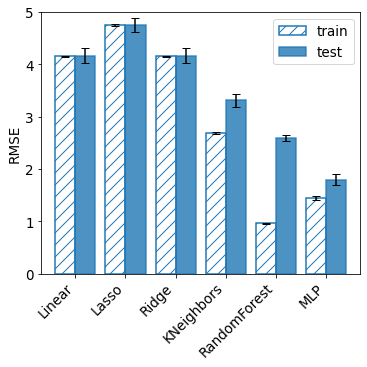

In [ ]:
best = {}
t = 'rmse'
for s in ['test', 'train']:
  best[s] = {}
  for i, key in enumerate(all_evals.keys()):
    mu = [np.mean([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    sigma = [np.std([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    if s == 'test':
      idx = 0
    else:
      idx = best['test'][key][0]
    best[s][key] = (idx, mu[idx], sigma[idx])
# make the chart
keys = list(best['test'].keys())
fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
for i, s in enumerate(['train', 'test']):
  if s == 'train':
    mf = 'none'
    h = '//'
    a = 1.0
  else:
    mf = 'tab:blue'
    h = ''
    a = 0.8
  ax.bar(np.arange(len(keys))+0.2*(2*i-1), [best[s][k][1] for k in keys], yerr=[best[s][k][2] for k in keys],
         width=0.40, label=s, color='tab:blue', facecolor=mf, alpha=a, edgecolor='tab:blue', hatch=h, linewidth=1.5, capsize=4)
ax.set_xticks(np.arange(len(keys)))
short_keys = [key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "") for key in keys]
ax.set_xticklabels(short_keys, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 5)
ax.set_ylabel('RMSE')
fig.tight_layout()

In [ ]:
best

{'test': {"<class 'sklearn.ensemble._forest.RandomForestRegressor'>": (0,
   2.5915664613530547,
   0.05843093045659063),
  "<class 'sklearn.linear_model._base.LinearRegression'>": (0,
   4.169263525024964,
   0.13856872773878068),
  "<class 'sklearn.linear_model._coordinate_descent.Lasso'>": (0,
   4.758734288709563,
   0.13379731726782482),
  "<class 'sklearn.linear_model._ridge.Ridge'>": (0,
   4.171258135002641,
   0.13917332044364947),
  "<class 'sklearn.neighbors._regression.KNeighborsRegressor'>": (0,
   3.314721475020589,
   0.12004455833622474),
  "<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>": (0,
   1.793893061243164,
   0.10516003370434684)},
 'train': {"<class 'sklearn.ensemble._forest.RandomForestRegressor'>": (0,
   0.9646343002139293,
   0.005269702020573133),
  "<class 'sklearn.linear_model._base.LinearRegression'>": (0,
   4.153914143360764,
   0.015585160907908928),
  "<class 'sklearn.linear_model._coordinate_descent.Lasso'>": (0,
   4.7594500

In [ ]:
fig.savefig('sequence-bar-rmse.pdf', bbox_inches='tight', pad_inches=0.05)

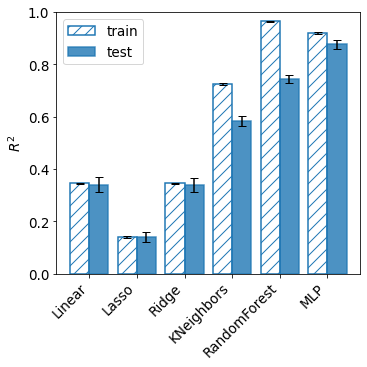

In [ ]:
best = {}
t = 'rsq'
for s in ['test', 'train']:
  best[s] = {}
  for i, key in enumerate(all_evals.keys()):
    mu = [np.mean([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    sigma = [np.std([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    if s == 'test':
      idx = 0
    else:
      idx = best['test'][key][0]
    best[s][key] = (idx, mu[idx], sigma[idx])
# make the chart
keys = list(best['test'].keys())
fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
for i, s in enumerate(['train', 'test']):
  if s == 'train':
    mf = 'none'
    h = '//'
    a = 1.0
  else:
    mf = 'tab:blue'
    h = ''
    a = 0.8
  ax.bar(np.arange(len(keys))+0.2*(2*i-1), [best[s][k][1] for k in keys], yerr=[best[s][k][2] for k in keys],
         width=0.40, label=s, color='tab:blue', facecolor=mf, alpha=a, edgecolor='tab:blue', hatch=h, linewidth=1.5, capsize=4)
ax.set_xticks(np.arange(len(keys)))
short_keys = [key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "") for key in keys]
ax.set_xticklabels(short_keys, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.set_ylabel('$R^2$')
fig.tight_layout()

In [ ]:
fig.savefig('sequence-bar-r2.pdf', bbox_inches='tight', pad_inches=0.05)

## make a chart for L

In [ ]:
model_metrics = {}
for L in range(0, 11):
  if L == 0:
    all_evals = joblib.load(os.path.join(drive_prefix, 'models', f'metrics-sequence.jbl'))
  else:
    all_evals = joblib.load(os.path.join(drive_prefix, 'models', f'metrics-L{L}.jbl'))
  model_metrics[L] = {}
  for key in all_evals.keys():
    # strip out the predictions for reduced memory usage
    gt, pred, metrics = all_evals[key]
    model_metrics[L][key] = metrics

In [ ]:
all_sigma = all_sigma[np.logical_not(np.isnan(all_sigma))]
all_sigma = all_sigma[all_sigma < 0.5]
print(all_sigma.mean(), all_sigma.std())
print(np.percentile(all_sigma, [0.25, 0.50, 0.75]))

0.07364707724213297 0.056695421191311796
[0.00566769 0.00606569 0.00646368]


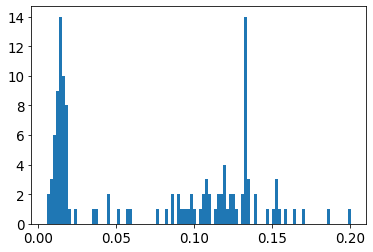

In [ ]:
_ = plt.hist(all_sigma, bins=100)

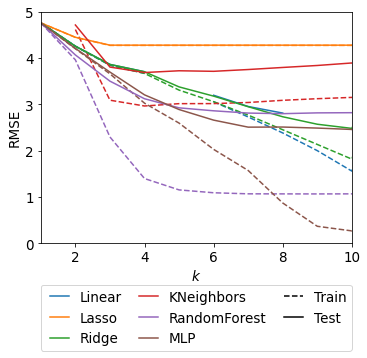

In [ ]:
from matplotlib import cm

all_sigma = np.zeros(0)

t = 'rmse'
fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
for s in ['train', 'test']:
  # key = "<class 'sklearn.linear_model._base.LinearRegression'>"
  for i, key in enumerate(all_evals.keys()):
    mu = [np.mean([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    sigma = [np.std([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    # break zero to one to indicate not the same strategy
    mu = np.hstack([mu[0], np.nan, mu[1:]])
    sigma = np.hstack([sigma[0], np.nan, sigma[1:]])
    all_sigma = np.hstack([all_sigma, sigma])
    # remove bad points
    mu[mu > 5] = np.nan
    # sigma[sigma > 1] = np.nan
    #
    short_key = key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "")
    # plot_x = np.hstack([11, np.nan, np.arange(10)+1])
    plot_x = np.hstack([11, np.nan, np.arange(10)+1])


    mu = np.hstack([mu[2:], mu[0]])
    plot_x = np.arange(11)+1

    if s == 'train':
      ls = '--'
      mf = 'none'
    else:
      ls = '-'
      mf = cm.tab10(i)
      ax.plot(np.nan, np.nan, linestyle='-', color=cm.tab10(i), label=short_key)

    # ax.errorbar(plot_x, mu, yerr=sigma, markerfacecolor=mf,
    #             linestyle=ls, marker='o', color=cm.tab10(i),
    #             alpha=1.0)#, markerfacecolor='none')
    ax.plot(plot_x, mu, color=cm.tab10(i), linestyle=ls)
    # ax.plot(plot_x[0], mu[0], marker='o', markerfacecolor=mf, color=cm.tab10(i))
    # ax.errorbar(plot_x[0], mu[0], sigma[0], marker='o', markerfacecolor=mf, color=cm.tab10(i))
    # ax.fill_between(plot_x[1:], mu[1:]-sigma[1:], mu[1:]+sigma[1:], alpha=0.33, color=cm.tab10(i))
    
ax.plot(np.nan, np.nan, 'k--', label='Train')
ax.plot(np.nan, np.nan, 'k-', label='Test')

ax.set_ylim([0, 5])
ax.set_xlim([1, 10])

ax.set_xlabel('$k$')
ax.set_ylabel(f'RMSE')
# set ticks
ticks = ax.get_xticks()
ticklabels = [f'{int(x):d}' if x != 0 else 'Full' for x in ticks]
_ = ax.set_xticklabels(ticklabels)
# Put a legend below current axis
# box = ax.get_position()
# a = 0.33
# ax.set_position([box.x0, box.y0, # + box.height * a,
#                 box.width, box.height * (1-a)])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, numpoints=3, handletextpad=0.5, columnspacing=1.0)
# ax.plot([10, 10], [0, 5], color=np.ones(3)*0.5, alpha=0.5)
fig.tight_layout()

In [ ]:
fig.savefig('rmse-kmers.pdf', bbox_inches='tight', pad_inches=0.05)

## bar chart from best results

{'test': {"<class 'sklearn.linear_model._base.LinearRegression'>": (8, 2.809512733160394, 0.11790513461378248), "<class 'sklearn.linear_model._coordinate_descent.Lasso'>": (5, 4.277564769922792, 0.13239981478470816), "<class 'sklearn.linear_model._ridge.Ridge'>": (10, 2.478417512543627, 0.1508916435703607), "<class 'sklearn.neighbors._regression.KNeighborsRegressor'>": (0, 3.314721475020589, 0.12004455833622474), "<class 'sklearn.ensemble._forest.RandomForestRegressor'>": (0, 2.5915664613530547, 0.05843093045659063), "<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>": (0, 1.793893061243164, 0.10516003370434684), 'LSTM': (0, 1.4867633700370788, 0.12496447859239773)}, 'train': {"<class 'sklearn.linear_model._base.LinearRegression'>": (8, 2.37994461918778, 0.013783327298768508), "<class 'sklearn.linear_model._coordinate_descent.Lasso'>": (5, 4.272490313666084, 0.014001844018523774), "<class 'sklearn.linear_model._ridge.Ridge'>": (10, 1.8144480601941737, 0.0158032514531

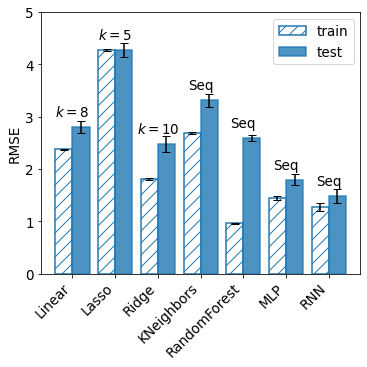

In [ ]:
best = {}
t = 'rmse'
for s in ['test', 'train']:
  best[s] = {}
  for i, key in enumerate(all_evals.keys()):
    mu = [np.mean([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    sigma = [np.std([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    if s == 'test':
      idx = np.argmin(mu)
    else:
      idx = best['test'][key][0]
    best[s][key] = (idx, mu[idx], sigma[idx])
# need to also load LSTM results
lstm_data = pd.read_csv(os.path.join(drive_prefix, 'models', 'lstm-cross-validation.csv'), index_col=0)
for s in ['Test', 'Train']:
  best[s.lower()]['LSTM'] = (0, lstm_data[f'{s} RMSE'].mean(), lstm_data[f'{s} RMSE'].std())
print(best)
# make the chart
keys = list(best['test'].keys())
fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
for i, s in enumerate(['train', 'test']):
  if s == 'train':
    mf = 'none'
    h = '//'
    a = 1.0
  else:
    mf = 'tab:blue'
    h = ''
    a = 0.8
  ax.bar(np.arange(len(keys))+0.2*(2*i-1), [best[s][k][1] for k in keys], yerr=[best[s][k][2] for k in keys],
         width=0.40, label=s, color='tab:blue', facecolor=mf, alpha=a, edgecolor='tab:blue', hatch=h, linewidth=1.5, capsize=4)
for i, k in enumerate(keys):
  b = best['test'][k][0]
  if b == 0:
    best_label = "Seq"
  else:
    best_label = f"$k={b}$"
  ax.text(i, max(best['test'][k][1], best['train'][k][1])+0.2, best_label, ha='center')
ax.set_xticks(np.arange(len(keys)))
short_keys = [key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "") for key in keys]
short_keys = [it if it != 'LSTM' else 'RNN' for it in short_keys]
ax.set_xticklabels(short_keys, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 5)
ax.set_ylabel('RMSE')
fig.tight_layout()

In [ ]:
fig.savefig('rmse-barchart.pdf', bbox_inches='tight', pad_inches=0.05)

{'test': {"<class 'sklearn.linear_model._base.LinearRegression'>": (8, 0.6991444330464509, 0.03142417631384287), "<class 'sklearn.linear_model._coordinate_descent.Lasso'>": (5, 0.30540155758957577, 0.029693531017132527), "<class 'sklearn.linear_model._ridge.Ridge'>": (10, 0.7659645386512534, 0.027919602146063646), "<class 'sklearn.neighbors._regression.KNeighborsRegressor'>": (0, 0.5831242208953847, 0.018976828561952198), "<class 'sklearn.ensemble._forest.RandomForestRegressor'>": (0, 0.7444765258066729, 0.017165429399440886), "<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>": (0, 0.8774780616536271, 0.01710345190296426), 'LSTM': (0, 0.881178051451311, 0.02502986544836235)}, 'train': {"<class 'sklearn.linear_model._base.LinearRegression'>": (8, 0.7851737611605925, 0.002856281889389103), "<class 'sklearn.linear_model._coordinate_descent.Lasso'>": (5, 0.3077015900004101, 0.003680422972328555), "<class 'sklearn.linear_model._ridge.Ridge'>": (10, 0.8751343821027027, 0.

Text(0, 0.5, '$R^2$')

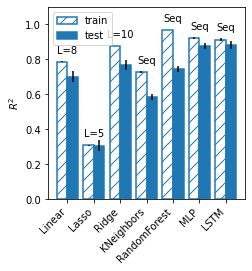

In [ ]:
best = {}
t = 'rsq'
for s in ['test', 'train']:
  best[s] = {}
  for i, key in enumerate(all_evals.keys()):
    mu = [np.mean([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    sigma = [np.std([m[s][t] for m in model_metrics[L][key]]) for L in range(0, 11)]
    if s == 'test':
      idx = np.argmax(mu)
    else:
      idx = best['test'][key][0]
    best[s][key] = (idx, mu[idx], sigma[idx])
# need to also load LSTM results
lstm_data = pd.read_csv(os.path.join(drive_prefix, 'models', 'lstm-cross-validation.csv'), index_col=0)
for s in ['Test', 'Train']:
  best[s.lower()]['LSTM'] = (0, lstm_data[f'{s} Rsq'].mean(), lstm_data[f'{s} Rsq'].std())
print(best)
# make the chart
keys = list(best['test'].keys())
fig, ax = plt.subplots(figsize=(3.54, 3.54))
for i, s in enumerate(['train', 'test']):
  if s == 'train':
    mf = 'none'
    h = '//'
  else:
    mf = 'tab:blue'
    h = 'none'
  ax.bar(np.arange(len(keys))+0.2*(2*i-1), [best[s][k][1] for k in keys], yerr=[best[s][k][2] for k in keys],
         width=0.40, label=s, color='tab:blue', facecolor=mf, edgecolor='tab:blue', hatch=h, linewidth=1.5)
for i, k in enumerate(keys):
  b = best['test'][k][0]
  if b == 0:
    best_label = "Seq"
  else:
    best_label = f"L={b}"
  ax.text(i, max(best['test'][k][1], best['train'][k][1])+0.05, best_label, ha='center')
ax.set_xticks(np.arange(len(keys)))
short_keys = [key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "") for key in keys]
ax.set_xticklabels(short_keys, rotation=45, ha='right')
ax.legend(loc='upper left', ncol=1)
ax.set_ylim(0, 1.1)
ax.set_ylabel('$R^2$')

In [ ]:
fig.savefig('rsq-barchart.pdf')